# Funguide: multi-class mushroom genus classification

Uses TensorFlow and TensorFlow Hub



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

In [4]:
labels_training = pd.read_csv("Data/labels_mushroom_train.csv")
labels_validation = pd.read_csv("Data/labels_mushrooms_val.csv")
labels_testing = pd.read_csv("Data/labels_mushrooms_test.csv")

In [5]:
filenames_train = [os.path.join("data","images","train", file) + ".jpg" for file in labels_training["id"]]
filenames_val = [os.path.join("data","images","val", file) + ".jpg" for file in labels_validation["id"]]
filenames_test = [os.path.join("data","images","test", file) + ".jpg" for file in labels_testing["id"]]

## Label Preparation

In [6]:
# Creating np arrays of genus type for train, test, and val sets
labels_train_np = labels_training["genus"]
labels_train_np = np.array(labels_train_np)

labels_val_np = labels_validation["genus"]
labels_val_np = np.array(labels_val_np)

labels_test_np = labels_testing["genus"]
labels_test_np = np.array(labels_test_np)

In [7]:
# Creating array of unique genus types
unique_genus = np.unique(labels_train_np)

In [8]:
# Converting np array of test, train, and val sets into booleans
labels_train_bool = [label == unique_genus for label in labels_train_np]
labels_val_bool = [label == unique_genus for label in labels_val_np]
labels_test_bool = [label == unique_genus for label in labels_test_np]

In [9]:
# Converting np boolean arrays into np integer arrays for train, test, and val sets
labels_train_int = []
for label in labels_train_bool:
   labels_train_int.append(label.astype(int))
labels_train_int = np.array(labels_train_int)

labels_test_int = []
for label in labels_test_bool:
  labels_test_int.append(label.astype(int))
labels_test_int = np.array(labels_test_int)

labels_val_int = []
for label in labels_val_bool:
  labels_val_int.append(label.astype(int))
labels_val_int = np.array(labels_val_int)

## Preprocessing images (turn into Tensor)

In [10]:

def preprocess_image(image_filepath):
  """
  Converts an image from its filepath into a Tensor.
  """
  image = tf.io.read_file(image_filepath)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[224, 224])
  return image

In [11]:
# Convert data into batches
def get_image_label(image_filepath, label):
  """
  Takes an image and its corresponding label, processes image, 
  returns a tuple with the label
  """
  processed_image = preprocess_image(image_filepath)
  return processed_image, label

In [12]:
BATCH_SIZE = 32

# create batches for testing

def create_data_batch(X, y=None, batch_size=BATCH_SIZE, validation_data=False, test_data=False):
    """
    Create batches of data from image-label pairs and shuffles for training.
    Data is not shuffled for validation.
    """
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # files, no labels
        data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
        return data_batch
    elif validation_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # files and labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data = data.map(get_image_label) # Image label tuple. Turns filepath into processed image
        data_batch = data.batch(BATCH_SIZE)
        return data_batch



In [13]:
# Create training and validation data

# All of the data. To be used after sample test
train_data = create_data_batch(filenames_train, labels_train_int)
val_data = create_data_batch(filenames_val, labels_val_int, validation_data=True)
test_data = create_data_batch(filenames_test, labels_test_int, validation_data=True)

# 1000 samples for model testing
#train_data = create_data_batch(filenames_train[:800], labels_train_int[:800])
#val_data = create_data_batch(filenames_val[:200], labels_val_int[:200])

## Visualizing data batch

In [14]:
train_images, train_labels = next(train_data.as_numpy_iterator())
val_images, val_labels = next(val_data.as_numpy_iterator())
test_images, test_labels = next(train_data.as_numpy_iterator())

## Build the model

Define:
* Input shape (image in Tensor form) to model
* The output shape (image labels, in Tensoor form) of our model
* URL of model to use

In [15]:
# Setup input shape to the model
INPUT_SHAPE = [None, 224, 224, 3] #batch, height, width, color channel

OUTPUT_SHAPE = len(unique_genus)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"


In [16]:
# Build model using keras

def build_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    """Creates a sequential model using Keras. Input shape is the shape of the processed images. 
    The output shape is the possible mushroom genera. Uses image recognition model from tfhub for transfer learning.
    Compiles model using Categorical Crossentropy loss function.
    """
    model = keras.Sequential(
      [
       hub.KerasLayer(MODEL_URL),
       tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                             activation="softmax")
       ]
       )
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
    model.build(INPUT_SHAPE)
    
    return model

## Use build_model() function to create 

In [17]:
# Model has already been built, this is commented out to avoid the long processing time of rebuilding the model.
#model = build_model()
#model.summary()

## Create callbacks

Helper functions model uses during training. Saves progress, checks progress, or stops training early


In [18]:
%load_ext tensorboard

In [19]:
def create_tensorboard():
  log_dir = os.path.join("/content/drive/MyDrive/Funguide/Logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              patience=3)

## Training the model
* Build the model using function
* set up a tensorboard helper function
* Call the fit() function on model, pass it training and validation data, and the number of epochs to train for. Also specify callbacks to use
* return model

In [21]:
# Trains the model for 100 epoches (unless early_stop is triggered)
NUM_EPOCHS = 100

In [22]:
# Model training function
def train_model():
  """
  Trains the model and returns it. Creates a tensorboard to track training accuracy.
  Uses an early stop with a patience of 3 to prevent overfitting.
  """
  model = build_model()

  tensorboard = create_tensorboard()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stop])
  
  return model

## Convert model's prediction probabilities to its label

In [23]:
def get_prediction_label(prediction_array):
  """
  Converts a prediction array into a label.
  """
  return unique_genus[np.argmax(prediction_array)]

In [24]:
# get_prediction_label(predictions[9])

In [25]:
# Get image from batched data

def unbatch_data(batch):
  """
  Takes a data batch and returns two lists containing the unbatched imagesa and labels.
  """
  images_unbatched = []
  labels_unbatched = []
  for image, label in batch.unbatch().as_numpy_iterator():
    images_unbatched.append(image)
    labels_unbatched.append(unique_genus[np.argmax(label)])
  return images_unbatched, labels_unbatched

#val_images, val_labels = unbatch_data(val_data)

In [26]:
def unbatch_image_data(batch):
  """
  Unatches image data, used for test data / user input data.
  """
  images_unbatched = []
  for image in batch.unbatch().as_numpy_iterator():
    images_unbatched.append(image)
  return images_unbatched

## Saving and reloading a trained model

In [27]:
# def save_model(model, suffix=None):
#   modeldir = os.path.join("/drive/MyDrive/Funguide/models",
#                           datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
#   model_path = modeldir + "-" + suffix + ".h5"
#   model.save(model_path)
#   return model_path


In [28]:
# def load_model(model_path):
#   model = tf.keras.models.load_model(model_path,
#                                      custom_objects={"KerasLayer":hub.KerasLayer})
#   return model

In [29]:
# Fit full model to all data
# model_all_data.fit(x=train_data,
#                    epochs=100,
#                   callbacks=[model_all_data_tensorboard, model_all_data_stop])

In [30]:
# Loading the previously trained model
loaded_model = tf.keras.models.load_model("funguide_saved_model.h5",
                                                       custom_objects={"KerasLayer": hub.KerasLayer})

## Test data run

In [31]:
test_data
test_predictions = loaded_model.predict(test_data,
                       verbose=1)
test_predictions


22/22 [==============================] - 5s 194ms/step


array([[3.15194759e-09, 6.72182421e-10, 7.54620366e-09, ...,
        9.99515295e-01, 1.81477403e-10, 4.82852309e-04],
       [5.59686475e-09, 1.30082313e-07, 9.99413967e-01, ...,
        5.40381334e-05, 1.45807462e-07, 5.27666882e-04],
       [1.55868165e-07, 1.32539171e-07, 1.60069405e-07, ...,
        9.96905386e-01, 3.05293268e-03, 4.70288001e-07],
       ...,
       [8.81266501e-12, 5.64761820e-07, 2.94872259e-19, ...,
        6.29426552e-07, 7.08023806e-10, 4.10694291e-11],
       [1.02512795e-05, 1.21211596e-02, 4.89847698e-05, ...,
        9.56589058e-02, 6.27632893e-04, 5.20956062e-04],
       [1.93225856e-06, 7.52039796e-06, 2.16987110e-06, ...,
        8.68834648e-03, 1.21966586e-04, 1.23902646e-04]], dtype=float32)

In [32]:
test_data

loaded_model.evaluate(test_data)

22/22 [==============================] - 5s 195ms/step - loss: 0.8389 - accuracy: 0.7938


[0.8389179110527039, 0.7937685251235962]

## Creating a confusion matrix for the model

In [33]:
one_dim_test_labels = []
for x in range(labels_test_int.shape[0]):
    one_dim_test_labels.append(np.argmax(labels_test_int[x]))

In [34]:
one_dim_test_labels = np.array(one_dim_test_labels)

In [35]:
one_dim_predictions = np.array([])
for x in range(test_predictions.shape[0]):
    one_dim_predictions = np.append(one_dim_predictions, [(np.argmax(test_predictions[x]))])

In [36]:
confusion_matrix = tf.math.confusion_matrix(one_dim_test_labels, one_dim_predictions, num_classes=9)

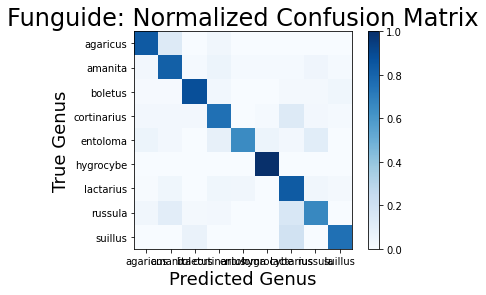

In [37]:
# Normalized confusion matrix
confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1).reshape(-1,1)

plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues);

plt.rcParams["figure.figsize"] = [20,20];

plt.title("Funguide: Normalized Confusion Matrix",fontsize=24);

tick_values = range(0,len(unique_genus))
plt.xticks(ticks=tick_values, labels=unique_genus.tolist());
plt.yticks(ticks=tick_values, labels=unique_genus.tolist());

plt.ylabel("True Genus", fontsize=18);
plt.xlabel("Predicted Genus", fontsize=18);
plt.colorbar();